## gpu 환경 세팅

In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-08-08 04:38:07.967479: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 04:38:08.004181: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


In [2]:
from __future__ import division
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal

AUTOTUNE = tf.data.experimental.AUTOTUNE

## 데이터 세트 불러오기 및 사용할 데이터 선택 

In [3]:
MODEL_NAME = 'DCGAN'
DATA_BASE_DIR = 'eardrumDs'
OUTPUT_PATH = os.path.join('outputs_tanh', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs_tanh", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
TARGET_IMG_SIZE = 128

BATCH_SIZE = 8
NOISE_DIM = 100
LAMBDA = 10 

EPOCHs = 10000
CURRENT_EPOCH = 1 
SAVE_EVERY_N_EPOCH = 15 

N_CRITIC = 2 #3
#LR = 1e-4
G_LR = 1e-4 #유지
D_LR = 1e-4 #유지
MIN_LR = 0.000001 
DECAY_FACTOR=1.00004 

file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

# 이미지 파일 경로 및 라벨을 저장할 리스트
list_ds = []

# 제외 폴더
exclude_folders = {'OtitExterna', 'Earventulation', 'Foreign', 'Earwax'}
exclude_files = {'.DS_Store'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(DATA_BASE_DIR):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    if label_folder in exclude_files:
            continue
    folder_path = os.path.join(DATA_BASE_DIR, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            list_ds.append(full_path)

for f in list_ds[:5]:
    print(f)

eardrumDs/Normal/normal_447.tiff
eardrumDs/Normal/normal_12.tiff
eardrumDs/Normal/normal_496.tiff
eardrumDs/Normal/normal_253.tiff
eardrumDs/Normal/normal_214.tiff


2024-08-08 04:38:10.308075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9773 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


## 이미지 전처리 및 확인

Training data shape: (755, 128, 128, 3)


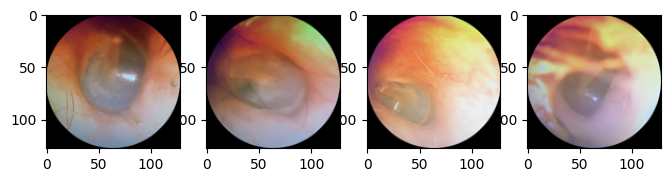

In [4]:
def load_and_normalize_image(path, target_size=(128, 128)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    image = image * 2 - 1
    return image

# 모든 이미지를 로드하고 정규화하여 리스트에 추가
images = [load_and_normalize_image(path) for path in list_ds]
images = np.array(images)

train_data = images
print("Training data shape:", train_data.shape)

fig = plt.figure(figsize=(10, 10))
nplot = 5
for i in range(1, nplot):
    ax = fig.add_subplot(1, nplot, i)
    #ax.imshow(train_data[i])
    ax.imshow((train_data[i] + 1) / 2) #tanh 전용
plt.show()

## 모델

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation, Input, LeakyReLU, Conv2DTranspose, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
import tensorflow as tf

def channel_attention(x):
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalAveragePooling2D()(x)
    dense_avg = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(avg_pool)
    dense_max = Dense(x.shape[-1], activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')(max_pool)
    combined = tf.keras.layers.add([dense_avg, dense_max])
    channel_attention = Activation('sigmoid')(combined)
    return tf.keras.layers.multiply([x, channel_attention])

def spatial_attention(x):
    avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    combined = Concatenate(axis=-1)([avg_pool, max_pool])
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(combined)
    return tf.keras.layers.multiply([x, spatial_attention])

def cbam_block(x):
    x = channel_attention(x)
    x = spatial_attention(x)
    return x

In [6]:
def CGAN_generator(input_z_shape):
    input_z_layer = Input(input_z_shape)
    
    z = Dense(4*4*512, use_bias=False, dtype='float32')(input_z_layer)
    z = Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (3, 3), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    #추가
    x = Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = cbam_block(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation="tanh", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    
    model = Model(inputs=input_z_layer, outputs=output)
    return model

def CGAN_discriminator(input_x_shape):
    input_x_layer = Input(input_x_shape)
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(input_x_layer)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = LeakyReLU()(x)
    
    #추가
    x = Conv2D(1024, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    x = LeakyReLU()(x)
    
    x = cbam_block(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02), dtype='float32')(x)
    
    x = Flatten()(x)
    
    output = Dense(1, dtype='float32')(x)
    
    model = Model(inputs=input_x_layer, outputs=output)
    return model

## 학습률, output 저장 및 그래프 생성

2024-08-08 04:38:14.282393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905


1/1 [==============================] - 1s 781ms/step


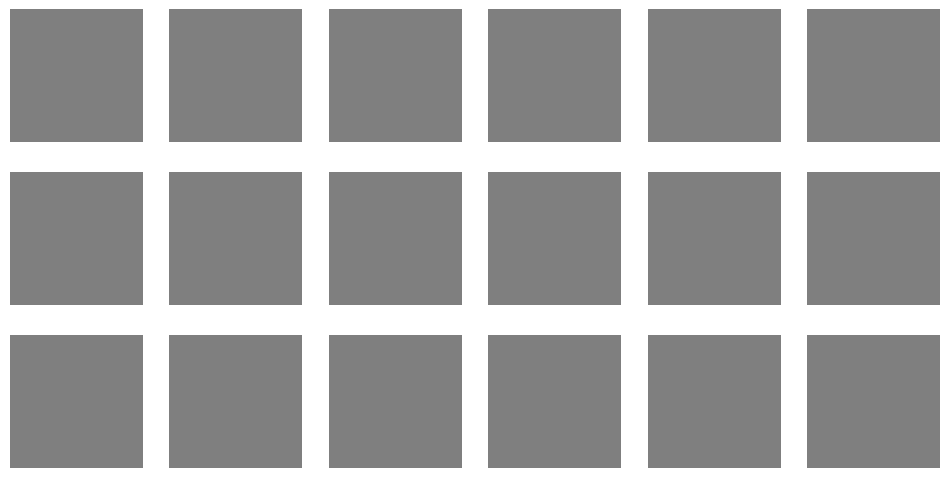

In [7]:
# generator = CGAN_generator()
# discriminator = CGAN_discriminator()
generator = CGAN_generator(input_z_shape=(NOISE_DIM,))
discriminator = CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3))

D_optimizer = Adam(learning_rate=D_LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=G_LR, beta_1=0.5)

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

def generate_latent_vector(batch_size, noise_dim):
    return tf.random.uniform(shape=(batch_size, noise_dim), minval=-1.0, maxval=1.0)

def generate_and_save_images(model, epoch, test_input, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    predictions = model.predict(test_input)
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32') # 필요 시 형태 바꾸기 
    fig = plt.figure(figsize=figure_size) #여기부터 이미지 시각화 
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5).clip(0,1)) #이미지 범위를 [0,1]로 바꾸기 
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

def graph(epochs_range, G_losses, D_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, G_losses, label='Generator Loss')
    plt.plot(epochs_range, D_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('WGAN Loss per Epoch & tanh & diff LR')
    plt.legend()
    plt.show()
    
num_examples_to_generate = 18

# We will reuse this seed overtime
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
generate_and_save_images(generator, 0, sample_noise, figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

## wgan loss

In [8]:
@tf.function
def WGAN_GP_train_d_step(real_image, batch_size, step):
    print("retrace")
    noise = generate_latent_vector(batch_size, NOISE_DIM)
    epsilon = tf.random.uniform(shape=[batch_size, 1, 1, 1], minval=0, maxval=1)
    
    # Train D
    with tf.GradientTape(persistent=True) as d_tape:
        with tf.GradientTape() as gp_tape:
            fake_image = generator(noise, training=True)
            fake_image_mixed = epsilon * tf.dtypes.cast(real_image, tf.float32) + ((1 - epsilon) * fake_image)
            fake_mixed_pred = discriminator(fake_image_mixed, training=True)
            
        # Compute gradient penalty
        grads = gp_tape.gradient(fake_mixed_pred, fake_image_mixed)
        grad_norms = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean(tf.square(grad_norms - 1))
        
        fake_pred = discriminator(fake_image, training=True)
        real_pred = discriminator(real_image, training=True)
        
        D_loss = tf.reduce_mean(fake_pred) - tf.reduce_mean(real_pred) + LAMBDA * gradient_penalty
        
    # Calculate the gradients for discriminator
    D_gradients = d_tape.gradient(D_loss, discriminator.trainable_variables)
    # Apply the gradients to the optimizer
    D_optimizer.apply_gradients(zip(D_gradients, discriminator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('D_loss', tf.reduce_mean(D_loss), step=step)
    
    return D_loss 

@tf.function
def WGAN_GP_train_g_step(real_image, batch_size, step):
    print("retrace")
    noise = generate_latent_vector(batch_size, NOISE_DIM)
    
    # Train G
    with tf.GradientTape() as g_tape:
        fake_image = generator(noise, training=True)
        fake_pred = discriminator(fake_image, training=True)
        G_loss = -tf.reduce_mean(fake_pred)
        
    # Calculate the gradients for generator
    G_gradients = g_tape.gradient(G_loss, generator.trainable_variables)
    
    # Apply the gradients to the optimizer
    G_optimizer.apply_gradients(zip(G_gradients, generator.trainable_variables))
    
    # Write loss values to tensorboard
    if step % 10 == 0:
        with file_writer.as_default():
            tf.summary.scalar('G_loss', G_loss, step=step)
    
    return G_loss 

## 학습

1/1 [==============================] - 0s 37ms/step


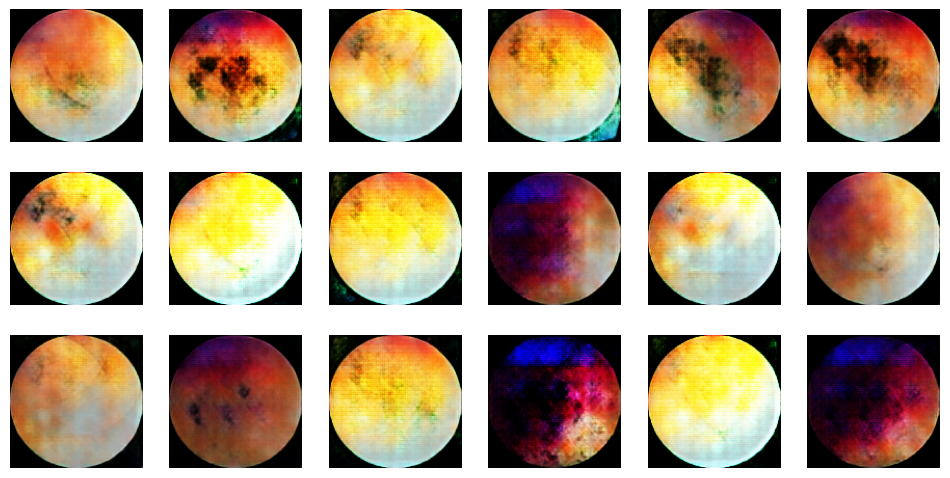

Time taken for epoch 23 is 208.07653880119324 sec

Current G losses:  tf.Tensor(-4.7886004, shape=(), dtype=float32)
Current D losses:  tf.Tensor(-2.588733, shape=(), dtype=float32)
Start of epoch 24
Generator learning rate 0.000100
Discriminator learning rate 0.000100
...............

In [ ]:
G_losses = []
D_losses = []

#current_learning_rate = LR
def set_learning_rate(generator_optimizer, discriminator_optimizer, g_lr, d_lr):
    generator_optimizer.learning_rate = g_lr
    discriminator_optimizer.learning_rate = d_lr

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=G_LR)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=D_LR)

trace = True
n_critic_count = 0

for epoch in range(CURRENT_EPOCH, EPOCHs + 1):
    start = time.time()
    print('Start of epoch %d' % (epoch,))
    # Using learning rate decay
    #current_learning_rate = learning_rate_decay(current_learning_rate)
    #print('current_learning_rate %f' % (current_learning_rate,))
    #set_learning_rate(current_learning_rate)
    
    G_LR = learning_rate_decay(G_LR)
    D_LR = learning_rate_decay(D_LR)
    print('Generator learning rate %f' % (G_LR,))
    print('Discriminator learning rate %f' % (D_LR,))
    set_learning_rate(generator_optimizer, discriminator_optimizer, G_LR, D_LR)
    
    epoch_G_loss = 0
    epoch_D_loss = 0
    steps_per_epoch = 0
    
    for step, image in enumerate(train_data):
        current_batch_size = image.shape[0]
        image = tf.expand_dims(image, axis=0)
        
        # Train critic (discriminator)
        #WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        D_loss = WGAN_GP_train_d_step(image, batch_size=tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
        epoch_D_loss += D_loss
        
        n_critic_count += 1
        if n_critic_count >= N_CRITIC: 
            # Train generator
            #WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            G_loss = WGAN_GP_train_g_step(image, batch_size= tf.constant(current_batch_size, dtype=tf.int64), step=tf.constant(step, dtype=tf.int64))
            epoch_G_loss += G_loss
            n_critic_count = 0
        
        steps_per_epoch += 1
        
        if step % 10 == 0:
            print ('.', end='')
    
    # 평균 손실 계산
    epoch_G_loss /= steps_per_epoch
    epoch_D_loss /= steps_per_epoch
    
    # 손실값 리스트에 추가
    G_losses.append(epoch_G_loss)
    D_losses.append(epoch_D_loss)
    
    clear_output(wait=True)
    generate_and_save_images(generator, epoch, sample_noise, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False)
    
    print ('Time taken for epoch {} is {} sec\n'.format(epoch,time.time()-start))

    print("Current G losses: ", G_losses[-1])
    print("Current D losses: ", D_losses[-1])
    
    if len(G_losses) >= 100 and len(D_losses) >= 100:
        epochs_range = range(epoch - len(G_losses) + 1, epoch + 1)
        graph(epochs_range, G_losses, D_losses)

In [ ]:
def graph(epochs_range, G_losses, D_losses):
    plt.figure(figsize=(20, 5))
    plt.plot(epochs_range, G_losses, label='Generator Loss')
    plt.plot(epochs_range, D_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('WGAN Loss per Epoch & tanh')
    plt.legend()
    plt.show()
    
epochs_range = range(epoch - len(G_losses) + 1, epoch + 1)
graph(epochs_range, G_losses, D_losses)